# Machine Learning and Chaotic attractors

Here we try to reproduce some [results](https://arxiv.org/pdf/1710.07313.pdf) by Pothak et al. 


In [73]:
import numpy as np

## $A$-matrix generation

Due to the paper the $A$ matrix represents the adjacency matrix of so-called sparse random Erdos–R􏰐enyi graph. There are three parameters that define it: $N$, $D$ and $\rho$. $N$ is just a size of matrix. $D$ is an average degree of a vertex. And the non-zero elements are taken to be uniformly distributed on the interval $(-a, a)$ whre $a$ is chosen in a such way that the maximum eigenvalue of $A$ is equal to $\rho$

In [74]:
from scipy.sparse import random as randm
from scipy import stats
from numpy.linalg import eigvals

def generate_A(N, D, rho):
    loc = -1
    scale = abs(loc*2)
    rvs = stats.uniform(loc = loc, scale = scale).rvs
    
    A = randm(N, N, density=D/N, data_rvs = rvs)
    A = np.tril(A.A) + np.tril(A.A, -1).T #to keep distribution and density right
    rescale = eigvals(A).max()/rho
    A = A/rescale
    return A

## $W_{in}$ generation

$W_{in}$ helps to transform low-dimensional input vector $u$ to $N$-dimensional vector. So, $W_{in}$ is a $N \times D_{in}$ matrix, where $D_{in}$ is the dimension of $u$. $W_{in}$ looks like vertical stack of diagonal $D_{in} \times D_{in}$ matrix, where diagonal elements are uniformly random in range $(-\sigma, \sigma)$.  

According to the paper the result of learning should not substentionally depend on $W_{in}$.

In [75]:
import random

def generate_W_in(N, D_input, sigma):
    dim = N//D_input #should be integer by design!
    
    W_in = np.zeros((D_input, D_input))
    for i in range(D_input):
        W_in[i][i] = random.uniform(-sigma, sigma)
        
    for j in range(dim-1):
        W_part = np.zeros((D_input, D_input))
        for i in range(D_input):
            W_part[i][i] = random.uniform(-sigma, sigma)
        W_in = np.vstack((W_in, W_part))
        
    return W_in

## Numerics for Lorenz attractor

Here we solve the system

$$\begin{cases} \dot{x} = \sigma(y - x) \\ \dot{y} = x(\rho - z) - y \\ \dot{z} = x y - \beta z \end{cases}$$,

with $\sigma = 10$, $\rho = 28$ and $\beta = 8/3$. The initial state is (1, 1, 1).

The numerical solution $u(t)$ for $T \in (0, 100)$ and $\Delta T = 0.02$ will provide trainig data for the reservoir. 

[1. 1. 1.]


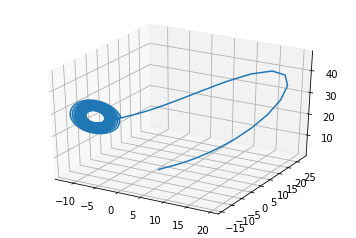

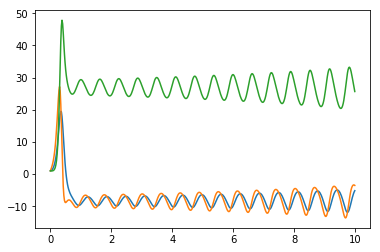

In [76]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
  x, y, z = state  # unpack the state vector
  return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 10.0, 0.02)

u = odeint(f, state0, t)

print(u[0,:])

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(u[:,0], u[:,1], u[:,2])
plt.show()

plt.plot(t[:1000], u[:, 0][:1000])
plt.plot(t[:1000], u[:, 1][:1000])
plt.plot(t[:1000], u[:, 2][:1000])
plt.show()


## Reservoir

Define reservoir function, which previous state `r`, input vector `a`, inner matrix `A` and return $\mathbf{r}(t+\Delta t) = \tanh\left[\mathbf{Ar}(t)+\mathbf{a}\right]$

In [77]:
def reservoir(r,a,A):
    arg = np.linalg.multi_dot([A,r])+a
    return np.tanh(arg)

print("test should be [0.604368, 0.53705, 0.604368]")
A = np.array([[1,2,3],[2,1,2],[3,2,1]])
r = np.array([0.1,0.1,0.1])
a = np.array([0.1,0.1,0.1])
print("test results "+str(reservoir(r,a,A)))

test should be [0.604368, 0.53705, 0.604368]
test results [0.60436778 0.53704957 0.60436778]


## Calculation
This function calculate outputs of our system for specific parameters `P`

In [78]:
def calculate(ncycles, A,W_in,P,r0,u0):
    r = [r0]
    v = [u0.tolist()]
    for i in range(0,ncycles):
        a = np.linalg.multi_dot([W_in,v[i]])
        newr = reservoir(r[i],a,A)
        rr = []
        for j in range(0,len(newr)):
            if j >= len(newr)//2:
                rr.append(newr[j]*newr[j])
            else:
                rr.append(newr[j])
        newrsq = np.array(rr);
        newv1 = np.linalg.multi_dot([P[0,:],newr])
        newv2 = np.linalg.multi_dot([P[1,:],newr])
        newv3 = np.linalg.multi_dot([P[2,:],newrsq])
        #print("newr")
        #print(newr)
        #print(newrsq)
        newv = np.array([newv1,newv2,newv3])
        r.append(newr)
        v.append(newv.tolist())
    return v

A = np.array([[1,2,3,2,1],[2,3,1,3,0],[3,1,3,1,0],[2,3,1,3,2],[1,0,0,2,1]])
print(eigvals(A))
W_in = np.array([[1,2,3,4,5],[2,3,4,5,6],[3,4,5,6,7]]).transpose()
P = np.array([[1,2,3,4,5],[2,3,4,5,6],[3,4,5,6,7]])
r = np.array([0.1,0.1,0.1,0.1,0.1])
a = np.array([0.1,0.1,0.1])
print(calculate(2,A,W_in,P,r,a))
print("by steps:\nA*r+Win*a")
print(reservoir(r,np.linalg.multi_dot((W_in,a)),A))



[ 8.85943311 -1.72140355 -0.94915859  3.13796861  1.67316043]
[[0.1, 0.1, 0.1], [14.525668278526508, 19.306420657326008, 23.682988492506798], [15.0, 20.0, 25.0]]
by steps:
A*r+Win*a
[0.90514825 0.94680601 0.96402758 0.9890274  0.97574313]


## Teaching functional
Let's use the following functional to minimize
$$
\sum\limits_{-T\leqslant t\leqslant 0} ||\mathbf{W}_{out}(\mathbf{r}(t),\mathbf{P})-\mathbf{v}_d(t)||^2+\beta ||\mathbf{P}||^2
$$

In [79]:
def teaching_functional(P,u,r0,A,W_in,beta):
    ncycles = len(u[:,0])-1;
    v = calculate(ncycles,A,W_in,P,r0,u[0,:])
    ret = 0;
    for i in range(0, ncycles+1):
        res = v[i]-u[i,:]
        ret += np.linalg.multi_dot([res,res])
    ret+=beta*np.vdot(P,P)
    return ret
    

## Minimization
Use Nelder-Mead Simplex algorithm

In [80]:
if False:
    from scipy.optimize import minimize
    insz = 30
    A = generate_A(insz,6,1.2)
    W_in = generate_W_in(insz,3,0.1)
    r0 = np.zeros(insz)
    P0 = generate_W_in(insz,3,0.1).flatten()

    v = calculate(10, A,W_in,P0.reshape((3,insz)),r0,u[0,:])
    print(v)

    print(teaching_functional(P0.reshape((3,insz)),u,r0,A,W_in,0))

    def func_lambda(P):
        return teaching_functional(P.reshape((3,insz)),u,r0,A,W_in,0)

    res = minimize(func_lambda, P0, method='nelder-mead',options={'xtol': 1e-2, 'disp': True})

    print(res)

Basinhopping with zero temperature

In [ ]:
if True:
    from scipy.optimize import basinhopping
    insz = 9
    A = generate_A(insz,2,1.2)
    W_in = generate_W_in(insz,3,0.1)
    r0 = np.zeros(insz)
    P0 = generate_W_in(insz,3,1).flatten()

    v = calculate(10, A,W_in,P0.reshape((3,insz)),r0,u[0,:])
    print(u)
    print(v)

    print(teaching_functional(P0.reshape((3,insz)),u,r0,A,W_in,0))

    def func_lambda(P):
        return teaching_functional(P.reshape((3,insz)),u,r0,A,W_in,0)

    res = basinhopping(func_lambda, P0, niter=10, T=0, stepsize=10)

    print(res)

[[ 1.          1.          1.        ]
 [ 1.04882146  1.52400084  0.97311434]
 [ 1.18686549  2.08854554  0.96173738]
 ...
 [-6.04606128 -3.38491281 27.7517652 ]
 [-5.5639896  -3.40676593 26.69259268]
 [-5.18331578 -3.53252053 25.66788895]]
[[1.0, 1.0, 1.0], [-0.003539176357688226, 0.019553593856610433, 0.018400408321876404], [0.01820172542709695, 0.017114668564486835, -0.003033560768232047], [-0.026324529854358427, 0.0013804846308257228, 0.0049907970850867085], [0.029672259192719284, 0.021445611969871783, -0.0063592300843747585], [-0.04070679639092699, 9.451831139399743e-05, 0.006658840188026935], [0.04373287577953303, 0.029934416587900595, -0.010780865860617047], [-0.06073509756111952, -0.0016997190905969012, 0.007949595430238448], [0.0644601118038868, 0.04186197611674827, -0.018659772636623627], [-0.0879065949800131, -0.004849111054954386, 0.007815515739979404], [0.09325302070493083, 0.05653349643683651, -0.03208693866653589]]
438371.61194026755
